[0.03223691]


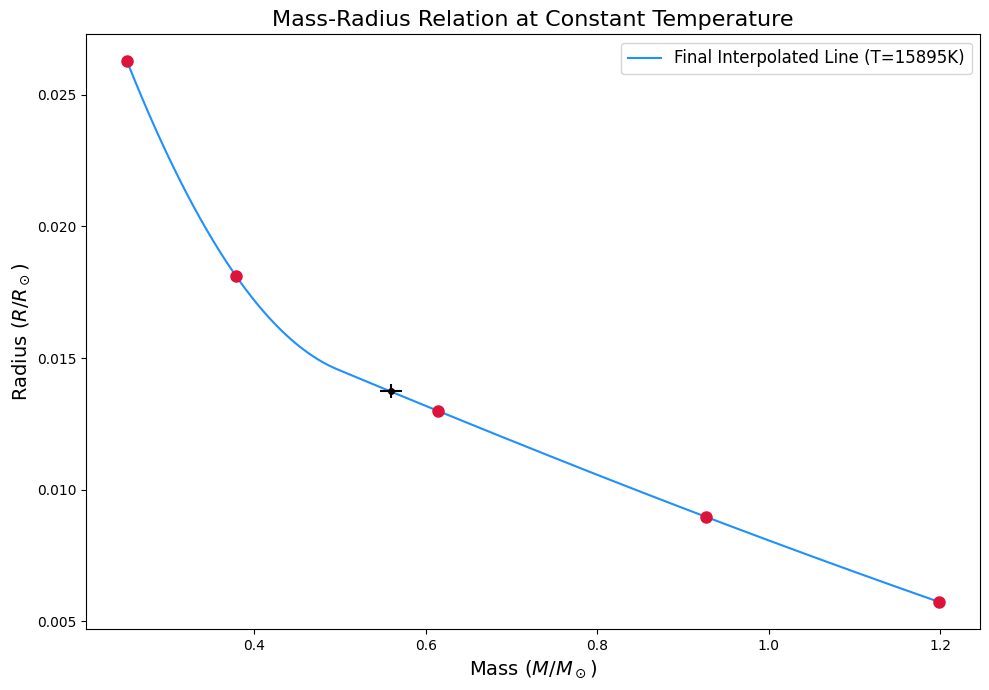

In [1]:
import pandas as pd
from scipy.interpolate import LinearNDInterpolator, interp1d
import numpy as np
import matplotlib.pyplot as plt

# STAGE 1: Use a 2D interpolator (LinearNDInterpolator) to find the specific
#          (Mass, Radius) values for several stellar models that all share
#          the exact same temperature.
#
# STAGE 2: Use a 1D interpolator (interp1d) to connect these new points,
#          creating a smooth Mass-Radius curve.

df = pd.read_csv('berg_tracks.csv')

wd_temperature = 15894.742185931427

# 'points' are the (Teff, logg) coordinates
points_2d = df[['Teff', 'logg']].values
# 'values' are the numbers we want to find at those coordinates
values_mass = df['M/Mo'].values   # The mass at each (Teff, logg) point
values_radius = df['R/Ro'].values # The radius at each (Teff, logg) point

# rescale=True when input dimensions (like Teff and logg) have very different scales.
mass_interpolator_2d = LinearNDInterpolator(points_2d, values_mass, rescale=True)
radius_interpolator_2d = LinearNDInterpolator(points_2d, values_radius, rescale=True)

unique_logg = sorted(df['logg'].unique())
# Create an array of query points: [[temp, logg1], [temp, logg2], ...]
stage1 = np.column_stack((np.full_like(unique_logg, wd_temperature), unique_logg)) # this creates a wd_temp array of the same size as uniquee_logg and stack them with unique_logg

interpolated_masses = mass_interpolator_2d(stage1)
interpolated_radii = radius_interpolator_2d(stage1)

points_at_const_temp = []
for i in range(len(unique_logg)):
    if not np.isnan(interpolated_masses[i]) and not np.isnan(interpolated_radii[i]):
        points_at_const_temp.append((interpolated_masses[i], interpolated_radii[i]))

points_at_const_temp = np.array(points_at_const_temp)

# For 1D interpolation, the x-values (mass) MUST be in increasing order.

points_at_const_temp = points_at_const_temp[points_at_const_temp[:, 0].argsort()] #first column, all rows are mass

mass_points = points_at_const_temp[:, 0]  
radius_values = points_at_const_temp[:, 1] 


radius_vs_mass_interpolator_1d = interp1d(mass_points, radius_values, kind='quadratic', bounds_error=False, fill_value=np.nan)

mass_grid = np.linspace(mass_points.min(), mass_points.max(), 100000)

interpolated_radius_line = radius_vs_mass_interpolator_1d(mass_grid)

  
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(mass_grid, interpolated_radius_line, color='dodgerblue',
            label=f'Final Interpolated Line (T={wd_temperature:.0f}K)')

ax.plot(mass_points, radius_values, 'o', color='crimson', markersize=8)
ax.errorbar(
    0.5594070939059468,
    0.01375917990021865,
    xerr=[[0.01231400504908342], [0.012332211965046858]],
    yerr=[[0.00026208243650054953], [0.00025844039172955025]], fmt = '.',
    color='black',
    markersize=8)

ax.set_xlabel('Mass ($M/M_\\odot$)', fontsize=14)
ax.set_ylabel('Radius ($R/R_\\odot$)', fontsize=14)
ax.set_title('Mass-Radius Relation at Constant Temperature', fontsize=16)
ax.legend(fontsize=12)

plt.tight_layout()
   
plt.savefig("mass_radius_relation_corrected.png")
print(radius_interpolator_2d([55000, 7.0]))